# Surface Tension Solver

This program takes the boundary points of a mesh, and due to the curvature between said points, and the surface tension coefficient, it finds the value for the surface tension on every node (clearly around the boundary).

Note: It is recommended to review the way in which the surface tension is defined, as there are several methods, and the one implemented tends to be very unstable.

In [14]:
#Setup FeniCs
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [49]:
from mshr import *
import matplotlib.pyplot as plt

#Define parameters for simplicity
#This block of code provides a general mesh case, it can be modified in accordance to the problem needed

rect2_1x = 4
rect2_1y = 2
rect2_1 = Point(rect2_1x,rect2_1y)

rect2_2x = 6
rect2_2y = 5
rect2_2 = Point(rect2_2x,rect2_2y)


rect2 = Rectangle(rect2_1, rect2_2)
circle = Circle(Point(5 , 2), 1 )

domain =  rect2 + circle
mesh = generate_mesh(domain, 500)

In [50]:
  #This block of code provides the filter, extracting only the nodes on the boundary.
  #Note that surface tension is clearly only defined over the boundary.

  import math
  class boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary

  V = FunctionSpace(mesh, "CG", 1)
  v = project(Expression("x[0]+x[1]", degree=2),V)
  mf = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
  boundary().mark(mf, 1)
  v2d = vertex_to_dof_map(V)
  dofs = []
  for facet in facets(mesh):
      if mf[facet.index()] == 1:
          vertices = facet.entities(0)
          for vertex in vertices:
              dofs.append(v2d[vertex])

  unique_dofs = np.array(list(set(dofs)), dtype=np.int32)
  boundary_coords1 = V.tabulate_dof_coordinates()[unique_dofs]


  boundary_coords_aux = [0]*len(boundary_coords1)

  for i in range(0,len(boundary_coords_aux)):
    boundary_coords_aux[i] = [boundary_coords1[i][0] , boundary_coords1[i][1]]


  def angle_with_reference(point, reference_point):
      x, y = point[0] - reference_point[0], point[1] - reference_point[1]
      return math.atan2(y, x)

  def sort_counterclockwise(points):
      # Find the centroid as the reference point
      reference_point = [sum(x[0] for x in points) / len(points), sum(x[1] for x in points) / len(points)]

      # Sort points based on the angle with the reference point
      sorted_points = sorted(points, key=lambda point: angle_with_reference(point, reference_point))

      return sorted_points

  boundary_coords = sort_counterclockwise(boundary_coords_aux)

  mesh_cords = [0]*len(boundary_coords)
  for i in range(0, len(boundary_coords)):
    mesh_cords[i] = Point(boundary_coords[i][0],boundary_coords[i][1])


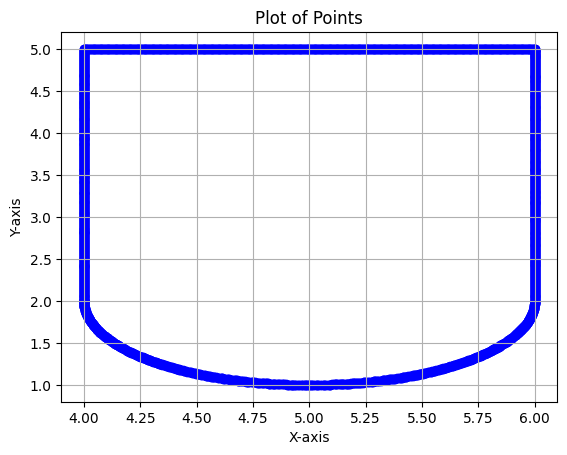

In [51]:
import matplotlib.pyplot as plt
#Block used to plot the points over the boundary
def plot_points(points):
    # Extract x and y coordinates from the list of points
    x_coordinates, y_coordinates = zip(*points)

    # Plot the points
    plt.scatter(x_coordinates, y_coordinates, color='blue', marker='o')
    plt.title('Plot of Points')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.show()

# Example usage:
points_list = boundary_coords
plot_points(points_list)


In [52]:
#Given Two Points, this function gives a unit normal vector to the line created by the two points
def normal_unit_vector(point1, point2):
    # Calculate the direction vector of the line
    direction_vector = np.array(point2) - np.array(point1)

    # Calculate the normal vector
    normal_vector = np.array([-direction_vector[1], direction_vector[0]])

    # Normalize the normal vector to get the unit normal vector
    unit_normal_vector = (normal_vector / np.linalg.norm(normal_vector))
    b = np.array(unit_normal_vector).tolist() #Changes to list, for compatibility
    b = [-1*b[0] , -1*b[1]] #Makes the vector outward
    return b





In [59]:
#Block in charge of calculating Surfae tension
import numpy as np
def calculate_curvature_and_force(points, surface_tension_coefficient, normal):
    n = len(points)
    curvature = np.zeros(n)
    surface_tension_force = np.zeros((n, 2))  # 2D force vector

    for i in range(1, n - 1): #Defines the second and first derivatives, in order to solve the finite differences problem for curvature estimation
        # Approximate first and second derivatives
        dx = points[i + 1][0] - points[i - 1][0]
        dy = points[i + 1][1] - points[i - 1][1]
        ds = np.sqrt(dx**2 + dy**2)

        x_prime = dx / (2 * ds)
        y_prime = dy / (2 * ds)

        dx_prime = points[i + 1][0] - 2 * points[i][0] + points[i - 1][0]
        dy_prime = points[i + 1][1] - 2 * points[i][1] + points[i - 1][1]

        x_double_prime = dx_prime / ds**2
        y_double_prime = dy_prime / ds**2

        # Calculate curvature
        curvature[i] = 0.5*np.abs(x_prime * y_double_prime - x_double_prime * y_prime) / (x_prime**2 + y_prime**2)**1.5 #Definition of survature

        # Calculate surface tension force
        surface_tension_force[i] = surface_tension_coefficient * curvature[i] * np.array(normal[i]) #Definition of Surface tension

    return curvature, surface_tension_force


#Filter the points on the  boundary to the ones on the bottom, as the top, left and right boundaries are bounded by a needle, meaning no force is applied there
filt= []
for i in range(0,len(boundary_coords)):
  if ((boundary_coords[i][1] == 5) or (boundary_coords[i][0] > 5.99) or (boundary_coords[i][0] < 4.01))  :
    k = 0
  else:
    filt.append(boundary_coords[i])



normalVectors = []
for i in range(0, len(filt)-1):
  n = normal_unit_vector(filt[i], filt[i+1])
  normalVectors.append(n)

st,Fst = calculate_curvature_and_force(filt, 0.0375,normalVectors )

In [ ]:
#Block in charge of plotting the surface tension forces
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm

def plot_points_and_vectors(points, vectors):
    fig, ax = plt.subplots()

    # Normalize vectors to make them unitary
    norms = np.linalg.norm(vectors, axis=1)
    unit_vectors = vectors / norms[:, np.newaxis]

    # Use a color map to represent vector magnitudes
    magnitudes = np.linalg.norm(vectors, axis=1)
    norm = Normalize(vmin=min(magnitudes), vmax=max(magnitudes))
    colors = cm.viridis(norm(magnitudes))

    # Define your custom scaling factor
    custom_scaling_factor = 0.1

    # Plot points
    ax.scatter(*zip(*points), color='red', s=5)

    # Plot normalized vectors with color map and varying size
    for i, point in enumerate(points):
        vector = custom_scaling_factor * unit_vectors[i]  # Adjust the length
        color = cm.viridis(norm(magnitudes[i]))

        # Scale the size based on the magnitude
        scale = 0.1
        ax.arrow(point[0], point[1], vector[0], vector[1], color=color,
                 head_width=0.2 * scale, head_length=0.2 * scale, fc=color, ec=color)

    ax.set_aspect('equal')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Surface Tension Force on the Boundary')

    # Resize the grid
    plt.grid(True, linewidth=0.5, alpha=0.5)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical', label='Force Magnitude [N]')

    plt.show()


def average_of_vectors(vectors):
    result = []

    for i in range(1, len(vectors)):
        avg_vector = [(vectors[i-1][0] + vectors[i][0]) / 2, (vectors[i-1][1] + vectors[i][1]) / 2]
        result.append(avg_vector)

    return result

# Example usage:

plot_points_and_vectors(filt, Fst)
